In [1]:
import pandas as pd
import numpy as np
import os
import scanpy as sc
import harmony
%matplotlib inline
#import bbknn
#import mnnpy
import seaborn as sns
import matplotlib.pyplot as plt

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:

def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

import sys
sys.path.append('/work/Xenopus/Notebooks/V3/Integrated_analysis/')
from Integrate import concat_for_harmony, adata_to_df

timepoints = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '/work/Xenopus/Notebooks/V3/intermediate_files', 'zUMI_raw_singlets' , timepoints)
counts = concat_for_harmony(adatas, timepoints)
norm_df = harmony.utils.normalize_counts(counts)

def adata_hvg(adata, N_genes = 1000):
    print(adata.obs.stage[0])
    counts = pd.DataFrame(data = adata.X.todense(), 
                          index = adata.obs_names,
                          columns = adata.var_names)
    norm_df = harmony.utils.normalize_counts(counts)
    hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=N_genes)
    return hvg_genes.tolist()

def flatten(ls):
    return [x for y in ls for x in y]
#hvg_genes_per_data = list(set(flatten([adata_hvg(x, N_genes = 500) for x in adatas])))

st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [3]:
df = pd.read_csv('/work/Xenopus/Notebooks/V3/misc_files/XENLA_XenBase20190115_prot.txt', sep = '\t', index_col = 0)
mapper = {x:h for x,h in zip(df.index, df['Unnamed: 5'])}
df_map = pd.DataFrame({'Data_name':counts.columns,
              'Reduced_name': [x.split('|')[1] for x in counts.columns]
             })
df_map['Human_name'] = df_map.Reduced_name.map(mapper)
mapper = {x:h for x, h in zip(df_map['Data_name'], df_map['Human_name'])}
#norm_df = norm_df.loc[:,hvg_genes_per_data]
norm_df.columns = [mapper[x] for x in norm_df.columns]
counts = norm_df.T
counts = counts[counts.index!= 'NoName']
counts = counts[~counts.index.isna()]
#counts = counts.reset_index().drop_duplicates(keep = 'first', subset='index').set_index('index')

#counts = counts.T
counts = counts.reset_index().groupby('index').mean()
#counts = counts.T

import pickle

with open('/work/Xenopus/Notebooks/V3/intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

tp = pd.Series(index=norm_df.index)
for t in timepoints:
    cells = norm_df.index[norm_df.index.str.contains(t)]
    tp[cells] = t
    
anno = pd.concat([clusters, tp], axis = 1)
anno.columns = ['Clusters', 'Stage']    


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [4]:
anno

anno['Clusters'] = anno['Clusters'].map(str)
anno['Cell-type'] = anno['Clusters'].map({ '7': 'P1','4': 'P2','0': 'Ep1' ,'2': 'Ep2','1': 'Ep3','5':'Ep4',   
                                                              '14': 'Bc1','12': 'Bc2','6': 'Bc3','3' : 'Bc4',
                                                              '9' : 'Mcc/CCPs','10' : 'Mcc2','13' : 'Mcc3',
                                                              '11': 'Ic',
                                                              '8': 'Gc' })
anno['Dataset'] = 'In House'

In [5]:
anno['Species'] = 'Xenopus'

In [6]:
# Remove pluripotent

In [7]:
#anno = anno[~anno['Cell-type'].str.startswith('P')]

In [8]:
#counts = counts[anno.index]

In [9]:
Pneuma_c = pd.read_csv('Garcia/Pneumacult_counts.tsv', sep = '\t', index_col = 0).T

In [10]:
Pneuma_m = pd.read_csv('Garcia/Pneumacult_meta.tsv', sep = '\t', index_col = 0)

In [11]:
Pneuma_m['Species'] = 'Human'

In [12]:
begm_c = pd.read_csv('Garcia/BEGM_counts.tsv', sep = '\t', index_col = 0).T

In [13]:
begm_m = pd.read_csv('Garcia/BEGM_meta.tsv', sep = '\t', index_col = 0)

In [14]:
begm_m['Species'] = 'Human'

In [15]:
#Filter undefined or unassigned celltypes

In [16]:
begm_m = begm_m[~begm_m['Cell-type'].str.startswith('U')]
begm_c = begm_c[begm_m.index]
begm_m['Cell-type'].unique()

array(['Suprabasal', 'Cycling Basal', 'Basal', 'Secretory like', 'MCCs',
       'Deuterosomal'], dtype=object)

In [17]:
Pneuma_m.Dataset = 'Garcia_pneuma'

In [18]:
begm_m.Dataset = 'Garcia_begm'

In [19]:
jaffe_h_c = pd.read_csv('Jaffe/Jaffe_human_counts.tsv', sep = '\t', index_col = 0)

In [20]:
jaffe_h_m = pd.read_csv('Jaffe/Jaffe_human_meta.tsv', sep = '\t', index_col = 0)

In [21]:
jaffe_h_m['Species'] = 'Human'

In [22]:
jaffe_m_c = pd.read_csv('Jaffe/Jaffe_mouse_counts.tsv', sep = '\t', index_col = 0)

In [23]:
jaffe_m_m = pd.read_csv('Jaffe/Jaffe_mouse_meta.tsv', sep = '\t', index_col = 0)

In [24]:
jaffe_m_m['Species'] = 'Mouse'

In [25]:
treutlein_c = pd.read_csv('Truetlein/Treutlein_counts.tsv', sep = '\t', index_col = 0)

In [26]:
treutlein_m = pd.read_csv('Truetlein/Treutlein_meta.tsv', sep = '\t', index_col = 0)

In [27]:
treutlein_m['Species'] = 'Mouse'

In [28]:
rajagopal_c = pd.read_csv('Rajagopal/rajagopal_counts.tsv', sep = '\t', index_col = 0)

In [29]:
rajagopal_m = pd.read_csv('Rajagopal/rajagopal_meta.tsv', sep = '\t', index_col = 0)

In [30]:
rajagopal_m['Species'] = 'Mouse'

In [31]:
teich_c = pd.read_csv('Teichmann/Teichmann_counts.tsv', sep = '\t', index_col = 0).T

In [32]:
teich_m = pd.read_csv('Teichmann/Teichmann_meta.tsv', sep = '\t', index_col = 0)

In [33]:
teich_m['Species'] = 'Human'

In [34]:
shalek_c = pd.read_csv('Shalek/Shalek_counts.tsv', sep = '\t', index_col = 0).T

In [35]:
shalek_m = pd.read_csv('Shalek/Shalek_meta.tsv', sep = '\t', index_col = 0)

In [36]:
shalek_m['Species'] = 'Human'

In [37]:
aztekin_c = pd.read_csv('Aztekin/Aztekin_counts.tsv', sep = '\t', index_col = 0)

In [38]:
aztekin_m = pd.read_csv('Aztekin/Aztekin_meta.tsv', sep = '\t', index_col = 0)

In [39]:
aztekin_m['Species'] = 'Xenopus'

In [40]:
klein_c = pd.read_csv('Klein/klein_nne_counts.tsv', sep = '\t', index_col = 0).T

In [41]:
klein_m = pd.read_csv('Klein/klein_nne_meta.tsv', sep = '\t', index_col = 0)

In [42]:
klein_m['Species'] = 'Xenopus'

## Multidataset correlation

In [45]:
from EvoDevo import main 

In [46]:
spearman, de_genes = main([counts, Pneuma_c, begm_c, jaffe_h_c, jaffe_m_c, treutlein_c, rajagopal_c, teich_c, shalek_c, aztekin_c, klein_c],
               [anno,   Pneuma_m, begm_m, jaffe_h_m, jaffe_m_m, treutlein_m, rajagopal_m, teich_m, shalek_m, aztekin_m, klein_m])

Doing DE round 0.0


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Clusters' as categorical
... storing 'Stage' as categorical
... storing 'Cell-type' as categorical
... storing 'Dataset' as categorical


Doing DE round 0.1


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Cluster' as categorical
... storing 'Dataset' as categorical
... storing 'Timepoint' as categorical
... storing 'type' as categorical
... storing 'Species' as categorical
... storing 'Cell-type' as categorical


Doing DE round 0.2


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Cluster' as categorical
... storing 'Dataset' as categorical
... storing 'Timepoint' as categorical
... storing 'type' as categorical
... storing 'Species' as categorical
... storing 'Cell-type' as categorical


Doing DE round 0.3


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Cluster' as categorical
... storing 'Donor' as categorical
... storing 'Cell-type' as categorical
... storing 'Dataset' as categorical


Doing DE round 0.4


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Cluster' as categorical
... storing 'Individual library (may be several per mouse)' as categorical
... storing 'Mouse' as categorical
... storing 'Timepoint' as categorical
... storing 'Cell-type' as categorical
... storing 'Dataset' as categorical


Doing DE round 0.5


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'time_point' as categorical
... storing 'sample' as categorical
... storing 'putative_cell_type' as categorical
... storing 'Cell-type' as categorical
... storing 'Dataset' as categorical


Doing DE round 0.6


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cluster' as categorical
... storing 'mouse' as categorical
... storing 'Cell-type' as categorical
... storing 'Dataset' as categorical


Doing DE round 0.7


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'orig.ident' as categorical
... storing 'location' as categorical
... storing 'celltype' as categorical
... storing 'ID' as categorical
... storing 'GEO_Sample' as categorical
... storing 'Dataset' as categorical
... storing 'Species' as categorical
... storing 'Cell-type' as categorical


Doing DE round 0.8


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'orig.ident' as categorical
... storing 'diagnosis' as categorical
... storing 'polyp' as categorical
... storing 'subset' as categorical
... storing 'Species' as categorical
... storing 'Dataset' as categorical
... storing 'Cell-type' as categorical


Doing DE round 0.9


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'DevelopmentalStage' as categorical
... storing 'cluster' as categorical
... storing 'CellCyclePhase' as categorical
... storing 'Dataset' as categorical
... storing 'Cell-type' as categorical
... storing 'Species' as categorical


Doing DE round 0.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'InDrops_version' as categorical
... storing 'Replicate_name' as categorical
... storing 'Clutch_name' as categorical
... storing 'Library_name' as categorical
... storing 'Barcode_name' as categorical
... storing 'Developmental_stage' as categorical
... storing 'Cluster_name' as categorical
... storing 'Parent_cluster_name' as categorical
... storing 'Dev_group' as categorical
... storing 'Cell-type' as categorical
... storing 'Dataset' as categorical
... storing 'Species' as categorical


Doing DE round 1.0
Doing DE round 1.1
Doing DE round 1.2
Doing DE round 1.3
Doing DE round 1.4
Doing DE round 1.5
Doing DE round 1.6
Doing DE round 1.7
Doing DE round 1.8
Doing DE round 1.9
Doing DE round 1.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 2.0
Doing DE round 2.1
Doing DE round 2.2
Doing DE round 2.3
Doing DE round 2.4
Doing DE round 2.5
Doing DE round 2.6
Doing DE round 2.7
Doing DE round 2.8
Doing DE round 2.9
Doing DE round 2.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 3.0
Doing DE round 3.1
Doing DE round 3.2
Doing DE round 3.3
Doing DE round 3.4
Doing DE round 3.5
Doing DE round 3.6
Doing DE round 3.7
Doing DE round 3.8
Doing DE round 3.9
Doing DE round 3.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 4.0
Doing DE round 4.1
Doing DE round 4.2
Doing DE round 4.3
Doing DE round 4.4
Doing DE round 4.5
Doing DE round 4.6
Doing DE round 4.7
Doing DE round 4.8
Doing DE round 4.9
Doing DE round 4.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 5.0
Doing DE round 5.1
Doing DE round 5.2
Doing DE round 5.3
Doing DE round 5.4
Doing DE round 5.5
Doing DE round 5.6
Doing DE round 5.7
Doing DE round 5.8
Doing DE round 5.9
Doing DE round 5.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 6.0
Doing DE round 6.1
Doing DE round 6.2
Doing DE round 6.3
Doing DE round 6.4
Doing DE round 6.5
Doing DE round 6.6
Doing DE round 6.7
Doing DE round 6.8
Doing DE round 6.9
Doing DE round 6.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 7.0
Doing DE round 7.1
Doing DE round 7.2
Doing DE round 7.3
Doing DE round 7.4
Doing DE round 7.5
Doing DE round 7.6
Doing DE round 7.7
Doing DE round 7.8
Doing DE round 7.9
Doing DE round 7.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 8.0
Doing DE round 8.1
Doing DE round 8.2
Doing DE round 8.3
Doing DE round 8.4
Doing DE round 8.5
Doing DE round 8.6
Doing DE round 8.7
Doing DE round 8.8
Doing DE round 8.9
Doing DE round 8.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 9.0
Doing DE round 9.1
Doing DE round 9.2
Doing DE round 9.3
Doing DE round 9.4
Doing DE round 9.5
Doing DE round 9.6
Doing DE round 9.7
Doing DE round 9.8
Doing DE round 9.9
Doing DE round 9.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.0


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.1


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.2


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.3


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.4


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.5


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.6


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.7


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.8


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.9


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Doing DE round 10.10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [ ]:
#spearman.to_csv('ct_correlation_complete.tsv', sep = '\t')

In [45]:
spearman = pd.read_csv('ct_correlation_complete.tsv', sep = '\t', index_col = 0)

In [46]:
counts_all = [counts, Pneuma_c, begm_c, jaffe_h_c, jaffe_m_c, treutlein_c, rajagopal_c, teich_c, shalek_c, aztekin_c, klein_c]
metas_all =  [anno,   Pneuma_m, begm_m, jaffe_h_m, jaffe_m_m, treutlein_m, rajagopal_m, teich_m, shalek_m, aztekin_m, klein_m]    

ls = []

for i in range(len(counts_all)):
    c = counts_all[i].T.copy()
    m = metas_all[i].copy()
    
    c['Cell-type'] = m['Dataset'].astype(str) + '_' + m['Cell-type'].astype(str)
    
    mean = c.groupby('Cell-type').mean().T
    glob_min = counts.mean(axis = 1)
    
    for col in mean.columns:
        mean[col] = mean[col].div(glob_min, axis = 0)
    
    ls.append(mean)

In [47]:
means = pd.concat(ls,axis = 1)

In [94]:
f = open("de_genes.pkl","rb")
de_genes = pickle.load(f)

In [49]:
for i in de_genes.keys():
    de_genes[i] = len(de_genes[i])

In [50]:
de = pd.DataFrame.from_dict(de_genes, columns = ['DE_genes'], orient='index').reset_index()

In [51]:
de.columns = ['ct', 'DE_genes']
de

,ct,DE_genes
0,In House_Bc1,1730
1,In House_Bc2,355
2,In House_Bc3,2066
3,In House_Bc4,756
4,In House_Ep1,3
...,...,...
154,Klein_placodal area,96
155,Klein_placodal neuron - eya2/neurog1/neurod1,1059
156,Klein_posterior placodal area,636
157,Klein_small secretory cells,967


In [172]:
de.to_csv('DE_genes.tsv', sep = '\t')

In [ ]:
# Load clustering from circular dendrogram

In [56]:
clust = pd.read_csv('Dendro_clusters.tsv', sep = '\t', index_col = 0)

In [104]:
bc = clust[(clust.clus == 1 )| (clust.clus == 5)]
ls_de = []
for i in bc.index:
    ls_de.extend(de_genes[i])
bc_genes = pd.Series(ls_de).value_counts()[pd.Series(ls_de).value_counts() > len(bc) / 5].index.tolist()

In [105]:
mcc = clust[(clust.clus == 4 )| (clust.clus == 7)]
ls_de = []
for i in mcc.index:
    ls_de.extend(de_genes[i])
mcc_genes = pd.Series(ls_de).value_counts()[pd.Series(ls_de).value_counts() > len(mcc) / 5].index.tolist()

In [106]:
sec = clust[(clust.clus == 3 ) | (clust.clus == 6) | (clust.clus == 8)]
ls_de = []
for i in sec.index:
    ls_de.extend(de_genes[i])
sec_genes = pd.Series(ls_de).value_counts()[pd.Series(ls_de).value_counts() > len(sec) / 5
                                           ].index.tolist()

In [107]:
bc_genes_clean = list(set(bc_genes) - (set(bc_genes) & set(mcc_genes) | (set(bc_genes) & set(sec_genes))))
                 
mcc_genes_clean = list(set(mcc_genes) - (set(mcc_genes) & set(sec_genes) | (set(mcc_genes) & set(bc_genes))))

sec_genes_clean = list(set(sec_genes) - (set(sec_genes) & set(mcc_genes) | (set(sec_genes) & set(bc_genes))))

In [109]:
means = means.div(means.sum()) * 10000 

In [110]:
means.replace(0, np.NaN, inplace = True)

In [111]:
merge_anno = pd.concat([anno,   Pneuma_m, begm_m, jaffe_h_m, jaffe_m_m, treutlein_m, rajagopal_m, teich_m, shalek_m, aztekin_m, klein_m], axis = 0)

In [112]:
spec_mapper = {x[0]:x[1] for x in merge_anno.groupby(['Dataset', 'Species']).count().index}

In [113]:
mapper = {1:'BCs',
          2:'EPs',
          3:'Secretory',
          4:'MCCs',
          5:'BCs',
          6:'Secretory',
          7:'MCCs',
          8:'Secretory',
          9:'Other',
          10:'Other', 
          11:'Other'}


In [118]:
#Cell type colors from integrated annotation
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])



In [140]:
df = pd.concat([bsc, mcc, sec], axis = 1)
df.columns = ['Basal cells', 'Cilliated cells', 'Secretory cells']

In [141]:
df = df.div(df.sum( axis = 1),axis = 0) * 100

In [142]:
df['Group'] = test.Type
df['Species'] = test.Species

In [143]:
df.to_csv('ternary_temp.txt', sep = '\t')
#df = pd.read_csv('ternary_temp.txt', sep = '\t', index_col = 0)

In [123]:
m = df[df.Group == 'MCCs']

In [ ]:
spec_map = {'Xenopus':'o', 'Mouse':'*', 'Human':'+'}
col_map = {'MCCs':13, 'Secretory':8, 'BCs':3, 'EPs':0}

In [ ]:
import ternary
spec_map = {'Xenopus':'o', 'Mouse':'*', 'Human':'+'}
col_map = {'MCCs':13, 'Secretory':8, 'BCs':3, 'EPs':0}

fig, tax = ternary.figure(scale=100)
fig.set_size_inches(6, 6)

#tax.scatter(df[['Basal cells', 'Cilliated cells', 'Secretory cells']].values, color='Grey')

for i in df.Species.unique(): 
    df_sub_test = df[df.Species == i]
    for j in df_sub_test.Group.unique():
        if j == 'Other':
            pass
        else:
            tax.scatter(df_sub_test[df_sub_test.Group == j].values, color=colors.iloc[col_map[j]].color, label=j + ' ' + i , s = 50, marker = spec_map[i])
        #tax.scatter(df_sub_test[df_sub_test.Group == 'Secretory'].values,  color = colors.iloc[8].color, label="Secretory", s = 50, marker = spec_map[i])
        #tax.scatter(df_sub_test[df_sub_test.Group == 'BCs'].values, color = colors.iloc[3].color, label="BCs", s = 50, marker = spec_map[i])
        #tax.scatter(df_sub_test[df_sub_test.Group == 'EPs'].values, color = colors.iloc[0].color, label="EPs", s = 50, marker = spec_map[i])

#tax.gridlines(multiple=60)
p1 = (50, 0, 0)
p2 = (100/3, 100/3, 100/3)
tax.line(p1, p2, linewidth=3., color='Grey', alpha = 0.1)
p1 = (0, 50, 0)
p2 = (100/3, 100/3, 100/3)
tax.line(p1, p2, linewidth=3., color='Grey', alpha = 0.1)

p1 = (50, 50, 0)
p2 = (100/3, 100/3, 100/3)
tax.line(p1, p2, linewidth=3., color='Grey', alpha = 0.1)
tax.get_axes().axis('off')
tax.ticks(axis='lbr', linewidth=1, multiple=50)

tax.legend(loc = 'upper right', frameon=False, bbox_to_anchor=(1.1, 1.1))
tax.left_axis_label("Secretory score", offset=0.14,fontsize = 14)
tax.right_axis_label("Mcc score", offset=0.14)
tax.bottom_axis_label("Basal score", offset=0.14)


plt.savefig('Figures2/ternary.pdf')


In [147]:
bc_score.score  = bc_score.score / bc_score.score.mean()# *100
mcc_score.score  = mcc_score.score / mcc_score.score.mean()# *100
sec_score.score  = sec_score.score / sec_score.score.mean() #*100

In [149]:
test = pd.concat([bc_score['score'], mcc_score['score'], sec_score['score']], axis = 1)
test = test.div(test.mean(axis = 1),axis = 0)
bc_score.score = test.iloc[:,0]
mcc_score.score = test.iloc[:,1]
sec_score.score = test.iloc[:,2]

In [150]:
scores = pd.concat([bc_score, mcc_score, sec_score], axis = 0).reset_index()
scores.columns = ['ID', 'score', 'group', 'score_type']
scores.loc[scores.group == 'Other'] = 0
scores.group.replace(0, 'Other', inplace = True)
scores.to_csv('scores.tsv', sep = '\t')
scores

,ID,score,group,score_type
0,Jaffe_mouse_Brush,1.344669,Secretory,BCs
1,Jaffe_mouse_Basal,0.882509,BCs,BCs
2,Jaffe_mouse_Cycling Basal (homeostasis),1.012847,BCs,BCs
3,Jaffe_mouse_Cycling Basal (regeneration),1.240440,BCs,BCs
4,Shalek_Fibroblast,2.555109,BCs,BCs
...,...,...,...,...
472,0,0.000000,Other,0
473,In House_Ep2,1.093940,EPs,Secretory
474,In House_Ep1,1.009222,EPs,Secretory
475,0,0.000000,Other,0


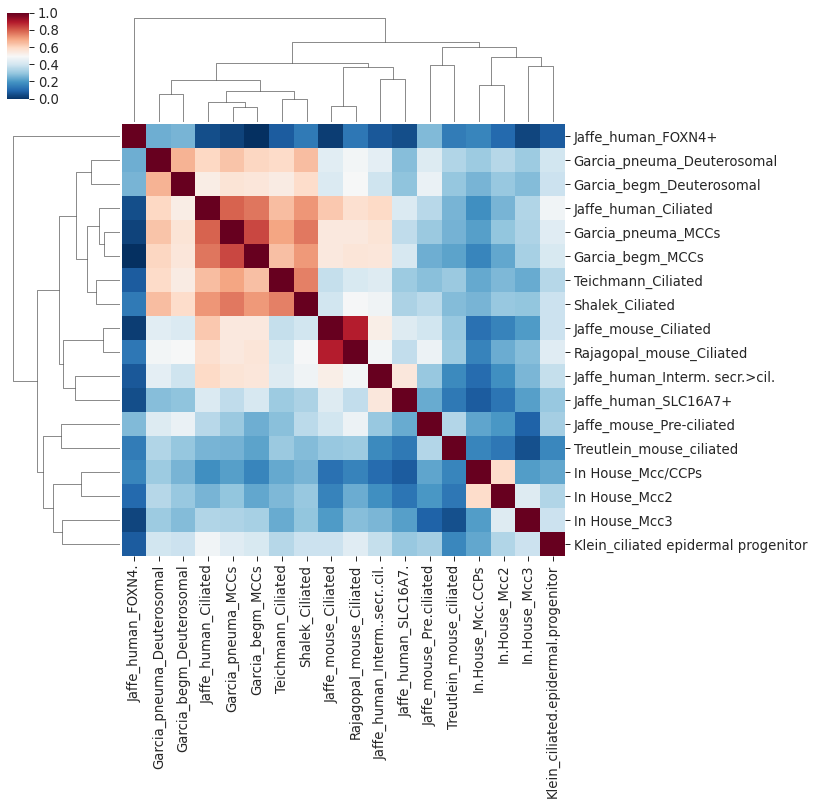

In [137]:
sns.clustermap(pd.read_csv('mcc.tsv', sep = '\t'), cmap = 'RdBu_r')
plt.savefig('Figures2/mcc_clustermap.pdf')

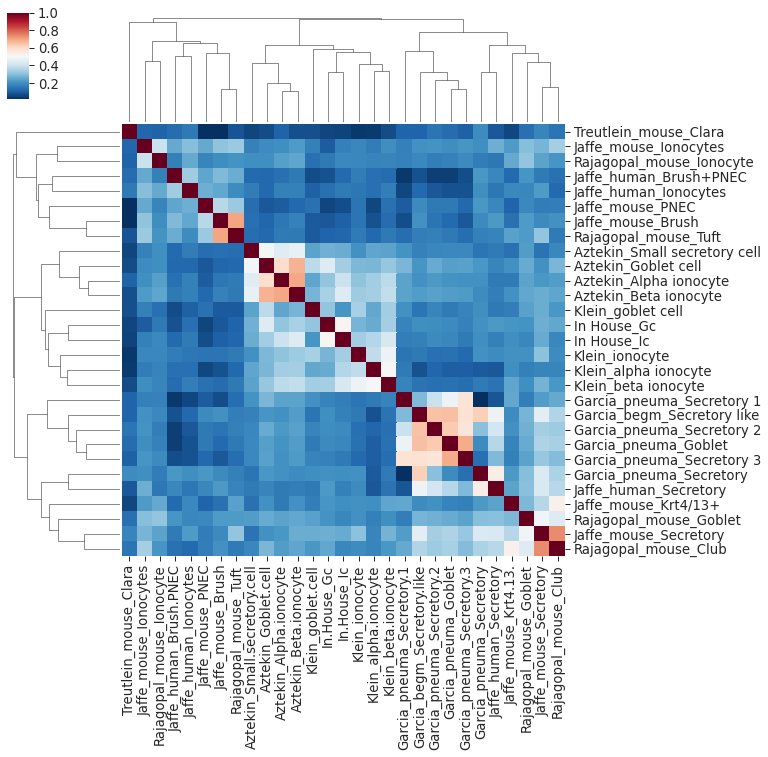

In [138]:
sns.clustermap(pd.read_csv('secretory.tsv', sep = '\t'), cmap = 'RdBu_r')
plt.savefig('Figures2/secretory_clustermap.pdf')

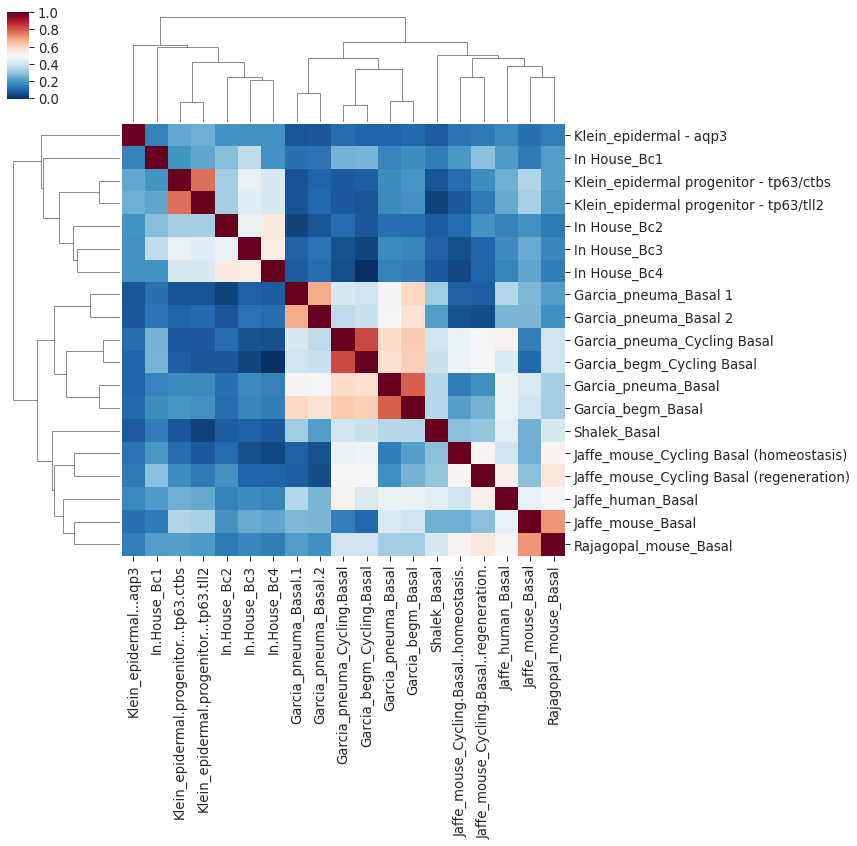

In [139]:
sns.clustermap(pd.read_csv('basal.tsv', sep = '\t'), cmap = 'RdBu_r')
plt.savefig('Figures2/basal_clustermap.pdf')